In [1]:
import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

# Salida determinística (comentar para aleatorizar el entrenamiento)
np.random.seed(1000)


In [2]:
# Optimizer
def GAN(latent_dim,output_shape):
  adam = Adam(lr=0.0002, beta_1=0.5)
  # Red Generadora
  generator = Sequential(name="generator")
  generator.add(Dense(256, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(512))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(1024))
  generator.add(LeakyReLU(0.2))
  generator.add(Dense(784, activation='tanh'))
  generator.add(Reshape(output_shape))
  # Red Discriminadora
  discriminator = Sequential(name="discriminator")
  discriminator.add(Flatten(input_shape=output_shape))
  discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Dense(512))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Dense(256))
  discriminator.add(LeakyReLU(0.2))
  discriminator.add(Dropout(0.3))
  discriminator.add(Dense(1, activation='sigmoid'))
  discriminator.compile(loss='binary_crossentropy', optimizer=adam)

  # No entrenar el discriminador al entrenar todo
  discriminator.trainable = False
  # Red GAN completa
  ganInput = Input(shape=(latent_dim,),name="input")
  x = generator(ganInput)
  ganOutput = discriminator(x)
  gan = Model(inputs=ganInput, outputs=ganOutput,name="GAN")
  gan.compile(loss='binary_crossentropy', optimizer=adam)
  return gan,discriminator,generator

In [3]:
# Cargar MNIST (solo x_train)
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32)/255)-0.5
X_train = X_train.reshape(60000, 28,28,1)
output_shape=(28,28,1)

# Dimensión latente 100
latent_dim = 100
#Crear el gan
gan,discriminator,generator = GAN(latent_dim,output_shape)

print(gan.summary())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "GAN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 100)               0         
_________________________________________________________________
generator (Sequential)       (None, 28, 28, 1)         1486352   
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________
None


In [4]:
# Dibujar el error en cada epoca
def plot_losses(d_losses,g_losses):
    plt.figure(figsize=(10, 8))
    plt.plot(d_losses, label='Discriminitive loss')
    plt.plot(g_losses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Dibujar imagenes generadas
def plot_images(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.title(f"Epoch {epoch}")
    plt.tight_layout()
    plt.show()

In [14]:
# entrena el gan
def train_gan(epochs, batch_size,gan,generator,discriminator,latent_dim):
    batches = X_train.shape[0] // batch_size
    tqdm.tqdm.write( f'Epochs:{epochs}')
    tqdm.tqdm.write( f'Batch size: {batch_size}')
    tqdm.tqdm.write( f'Batches per epoch: {batches}')

    d_losses = []
    g_losses = []
    for e in range(0, epochs):
        for _ in tqdm.tqdm_notebook(range(batches),desc=f"Epoch {e+1}"):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            # Generate fake MNIST images
            fake_images_batch = generator.predict(noise)
            # Imagenes reales aleatorias
            real_images_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
            # Genero un batch para el discriminador
            x_discriminator = np.concatenate([real_images_batch, fake_images_batch])
            y_discriminator = np.concatenate([np.ones(batch_size)*0.9,np.zeros(batch_size)])
            
            # Entrenar discriminador
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(x_discriminator, y_discriminator)
            discriminator.trainable = False

            # Entrenar generador
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_generator = np.ones(batch_size)
            
            g_loss = gan.train_on_batch(noise, y_generator)

        # Guardar losses del ultimo batch
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        #dibujar imagenes generadas
        if e == 0 or e % 5 == 0:
            plot_images(e)
    return d_losses,g_losses

Epochs:30
Batch size: 128
Batches per epoch: 468


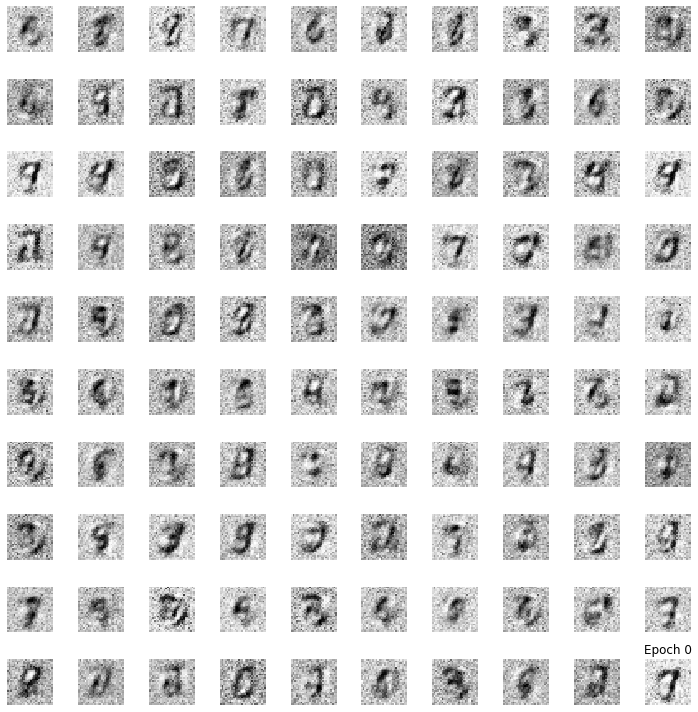

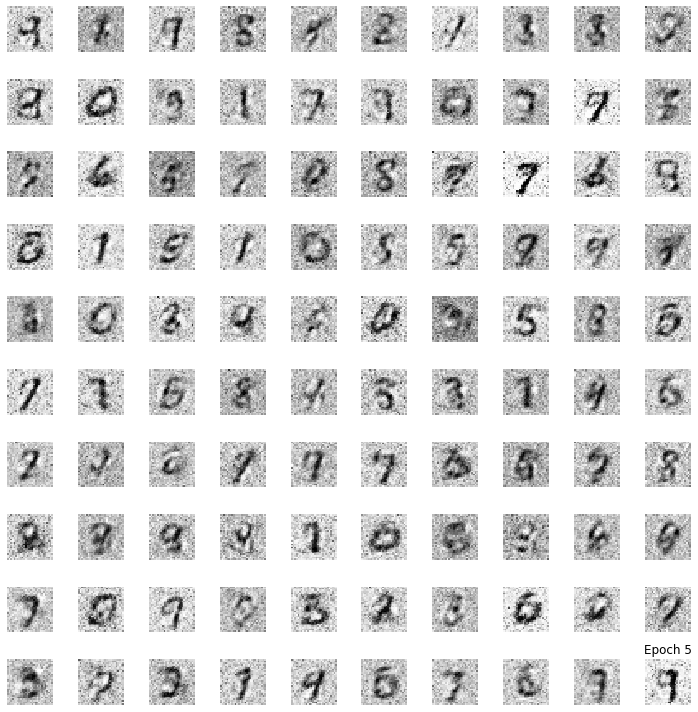

KeyboardInterrupt: 

In [15]:
batch_size = 128
epochs = 30

d_losses,g_losses= train_gan(epochs,batch_size,gan,generator,discriminator,latent_dim)
plot_losses(d_losses,g_losses)